In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score, make_scorer, accuracy_score, precision_score, classification_report, f1_score, roc_auc_score, average_precision_score, fbeta_score, log_loss
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from hyperopt import hp, tpe, fmin, STATUS_OK, Trials, STATUS_FAIL
from sklearn.base import clone
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm
import xgboost as xgb

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hr-analytics-dataset/HR_Analytics.csv


In [2]:
data = pd.read_csv('/kaggle/input/hr-analytics-dataset/HR_Analytics.csv')
with pd.option_context('display.max_columns', None):
    display(data.head())

,EmpID,Age,AgeGroup,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,SalarySlab,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,RM297,18,18-25,Yes,Travel_Rarely,230,Research & Development,3,3,Life Sciences,1,405,3,Male,54,3,1,Laboratory Technician,3,Single,1420,Upto 5k,25233,1,Y,No,13,3,3,80,0,0,2,3,0,0,0,0.0
1,RM302,18,18-25,No,Travel_Rarely,812,Sales,10,3,Medical,1,411,4,Female,69,2,1,Sales Representative,3,Single,1200,Upto 5k,9724,1,Y,No,12,3,1,80,0,0,2,3,0,0,0,0.0
2,RM458,18,18-25,Yes,Travel_Frequently,1306,Sales,5,3,Marketing,1,614,2,Male,69,3,1,Sales Representative,2,Single,1878,Upto 5k,8059,1,Y,Yes,14,3,4,80,0,0,3,3,0,0,0,0.0
3,RM728,18,18-25,No,Non-Travel,287,Research & Development,5,2,Life Sciences,1,1012,2,Male,73,3,1,Research Scientist,4,Single,1051,Upto 5k,13493,1,Y,No,15,3,4,80,0,0,2,3,0,0,0,0.0
4,RM829,18,18-25,Yes,Non-Travel,247,Research & Development,8,1,Medical,1,1156,3,Male,80,3,1,Laboratory Technician,3,Single,1904,Upto 5k,13556,1,Y,No,12,3,4,80,0,0,0,3,0,0,0,0.0


In [3]:
summ = data.groupby('Attrition').agg(count = pd.NamedAgg(column = 'EmpID', aggfunc = 'count'))
summ['perc_total'] = summ['count']/summ['count'].sum()
summ

,count,perc_total
Attrition,,
No,1242,0.839189
Yes,238,0.160811


In [4]:
[np.nan] * 6

[nan, nan, nan, nan, nan, nan]

In [5]:
list({1:2, 2:3}.values())

[2, 3]

In [6]:
with pd.option_context('display.max_columns', None):
    display(data.describe())

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1480.000000,1480.000000,1480.000000,1480.000000,1480.0,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.0,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1423.000000
mean,36.917568,801.384459,9.220270,2.910811,1.0,1031.860811,2.724324,65.845270,2.729730,2.064865,2.725000,6504.985811,14298.460811,2.687162,15.210135,3.153378,2.708784,80.0,0.791892,11.281757,2.797973,2.760811,7.009459,4.228378,2.182432,4.118060
std,9.128559,403.126988,8.131201,1.023796,0.0,605.955046,1.092579,20.328266,0.713007,1.105574,1.104137,4700.261400,7112.056802,2.494098,3.655338,0.360474,1.081995,0.0,0.850527,7.770870,1.288791,0.707024,6.117945,3.616020,3.219357,3.555484
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,493.750000,2.000000,48.000000,2.000000,1.000000,2.000000,2922.250000,8051.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,800.000000,7.000000,3.000000,1.0,1027.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4933.000000,14220.000000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1568.250000,4.000000,83.000000,3.000000,3.000000,4.000000,8383.750000,20460.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [7]:
np.percentile(np.array([1,2,3,4,5,6,7,8,9]), 100)

9.0

In [8]:
class FeatureSelector:
    def check_cols_nulls(df):
        null = df.isna().sum()
        null = null[null>0]
        for col in null.index:
            print(f"{col}: {100*null[col]/len(df): 0.2f}% null")
        return list(null.index)
    
    def get_num_cols(df):
        dtypes = df.dtypes.to_dict()
        num_cols = []
        for col, dtype in dtypes.items():
            if dtype in ['float', 'int']:
                num_cols.append(col)
        return num_cols
    
    def get_cat_cols(df, max_cat = 50):
        max_cat = min(max_cat, len(df) * 0.2)
        dtypes = df.dtypes.to_dict()
        cat_cols = []
        for col, dtype in dtypes.items():
            if dtype == 'object' and df[col].nunique() < max_cat:
                cat_cols.append(col)
        return cat_cols        
        
    def labelencode(df, column, mapping = None):
        colname = f'LE_{column}'
        if colname in df.columns:
            df = df.drop([colname], axis = 1)
        if not mapping:
            mapping = {}
            for i, k in enumerate(df[column].unique()):
                mapping[k] = i + 1
        df[colname] = df[column].map(mapping)
        return df
    
    def onehotencode(df, column, value_map = None, prefix = None):
        if prefix is None:
            prefix = column
        if value_map:
            df[column] = df[column].map(value_map)
        concat = pd.get_dummies(df[column], prefix = prefix)
        df = pd.concat([df, concat], axis = 1)
        return df
    
    def drop_no_var(df):
        for col in df.columns:
            if df[col].nunique() <= 1:
                df = df.drop([col], axis = 1)
                print(f"Dropped Column {col}: No Variance")
        return df
    
    def bool_to_int(df, columns = None):
        if not columns:
            columns = df.columns
        dtypes = df.dtypes.to_dict()
        for col, dtype in dtypes.items():
            if dtype == 'bool' and col in columns:
                df[col] = df[col].astype(int)
        return df
    
    def get_high_corr_vars(df, threshold = 0.9):
        num_cols = FeatureSelector.get_num_cols(df)
        corr_mat = df[num_cols].corr()
        mask = np.triu(np.ones_like(corr_mat, dtype=bool), k=0)
        corr_mat = corr_mat.where(~mask)
        for col in corr_mat:
            for ind in corr_mat[corr_mat[col] >= threshold].index:
                print(f"{col} - {ind}: {corr_mat.loc[ind, col]:0.2f}")
    
class Models:
    import warnings
    warnings.filterwarnings('ignore')
    
    def fbeta(precision, recall, beta = 1):
        return (1 + beta ** 2) * (precision * recall)/(beta ** 2 * precision + recall)
    
    def classification_metrics(y_true, y_proba, thresh_perc = 80):
        threshold = np.percentile(y_proba, thresh_perc)
        y_pred = (y_proba >= threshold).astype(int)
        
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'f2': fbeta_score(y_true, y_pred, beta = 2),
            'roc_auc': roc_auc_score(y_true, y_proba),
            'pr_auc': average_precision_score(y_true, y_proba)
        }
    
        return metrics
    
    def cross_validation(model, X, y, folds=5):
        kf = KFold(n_splits=folds, shuffle=True)
        metrics = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'f2': [],
            'roc_auc': [],
            'pr_auc': []
        }
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y.loc[train_index], y.loc[test_index]

            # Clone the model to avoid fitting it on the same data
            model_clone = clone(model)
            model_clone.fit(X_train, y_train)

            y_proba = model_clone.predict_proba(X_test)[:,1]
            
            results = Models.classification_metrics(y_test, y_proba)
            
            # Calculate metrics
            metrics['accuracy'].append(results['accuracy'])
            metrics['precision'].append(results['precision'])
            metrics['recall'].append(results['recall'])
            metrics['f1'].append(results['f1'])
            metrics['f2'].append(results['f2'])
            metrics['roc_auc'].append(results['roc_auc'])
            metrics['pr_auc'].append(results['pr_auc'])

        avg_metrics = {key: np.mean(value) for key, value in metrics.items()}
        return avg_metrics
    
    def optimize_model(space, model, X, y, max_trials = 200, verbose = 1):
        def objective(params):
            
            for name, k in params.items():
                if isinstance(k, (int, float)) and int(k) == k:
                    params[name] = int(k)
            
            
            model_copy = clone(model)
            model_copy.set_params(**params)
            
            try:
                metrics = Models.cross_validation(model_copy, X, y)
                
                if verbose > 0:
                    print(params)
                    print(f"{params}: {metrics}")
                    
                loss = ((metrics['precision']) * (metrics['precision']>0.2)) * (metrics['recall']) * (metrics['recall'] > 0.4)

                result = {
                    'loss': -loss,  
                    'status': STATUS_OK,
                    'metrics': metrics
                }
        
            except Exception as e:
                if verbose > 0:
                    print(f"Invalid Parameter")
                metrics = {
                    'accuracy': np.nan,
                    'precision': np.nan,
                    'recall': np.nan,
                    'fbeta': np.nan,
                    'roc_auc': np.nan,
                    'prauc': np.nan,
                    'logloss': np.nan
                }

                result = {'loss': np.nan, 'status': STATUS_FAIL, 'metrics': np.nan}

            #results_df = pd.read_csv(filesave)
            #results_df.loc[len(results_df)] = [len(results_df), result['loss'], result['status']] + list(metrics.values())
            #results_df.to_csv(filesave, index = None)
            return result

        
        trials = Trials()
        best = fmin(
            fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=max_trials,
            trials=trials
        )

        trial_results = []
        for trial in trials:
            trial_result = trial['result']
            trial_results.append({
                'params': trial['misc']['vals'],
                'metrics': trial_result['metrics'],
                'loss': trial_result['loss'],
                'status': trial_result['status']
            })

        df_results = pd.DataFrame(trial_results)
        df_results = df_results[df_results['status'] == 'ok']
        df_metrics = df_results['metrics'].apply(pd.Series)

        df_results = pd.concat([df_results.drop(columns=['metrics']), df_metrics], axis=1)
        
        return best, df_results.sort_values(by = 'loss')

##### Among all the columns, only 'YearsWithCurrManager' has null values. We will impute this with the mean.

In [9]:
FeatureSelector.check_cols_nulls(data)
data['YearsWithCurrManager'] = data['YearsWithCurrManager'].fillna(data['YearsWithCurrManager'].mean())

YearsWithCurrManager:  3.85% null


In [10]:
data = FeatureSelector.drop_no_var(data)

Dropped Column EmployeeCount: No Variance
Dropped Column Over18: No Variance
Dropped Column StandardHours: No Variance


In [11]:
cat_cols = FeatureSelector.get_cat_cols(data)
cat_cols

['AgeGroup',
 'Attrition',
 'BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'SalarySlab',
 'OverTime']

In [12]:
data = FeatureSelector.labelencode(data, 'AgeGroup', {'18-25':1, '26-35':2, '36-45':3, '46-55':4, '55+':5})
data['AgeGroup'].value_counts()

AgeGroup
26-35    611
36-45    471
46-55    228
18-25    123
55+       47
Name: count, dtype: int64

In [13]:
data = FeatureSelector.labelencode(data, 'Attrition', {'Yes': 1, 'No': 0})
data = data.rename(columns = {'LE_Attrition': 'target'})
data['Attrition'].value_counts()

Attrition
No     1242
Yes     238
Name: count, dtype: int64

In [14]:
data

,EmpID,Age,AgeGroup,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,LE_AgeGroup,target
0,RM297,18,18-25,Yes,Travel_Rarely,230,Research & Development,3,3,Life Sciences,...,0,0,2,3,0,0,0,0.0,1,1
1,RM302,18,18-25,No,Travel_Rarely,812,Sales,10,3,Medical,...,0,0,2,3,0,0,0,0.0,1,0
2,RM458,18,18-25,Yes,Travel_Frequently,1306,Sales,5,3,Marketing,...,0,0,3,3,0,0,0,0.0,1,1
3,RM728,18,18-25,No,Non-Travel,287,Research & Development,5,2,Life Sciences,...,0,0,2,3,0,0,0,0.0,1,0
4,RM829,18,18-25,Yes,Non-Travel,247,Research & Development,8,1,Medical,...,0,0,0,3,0,0,0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,RM412,60,55+,No,Travel_Rarely,422,Research & Development,7,3,Life Sciences,...,0,33,5,1,29,8,11,10.0,5,0
1476,RM428,60,55+,No,Travel_Frequently,1499,Sales,28,3,Marketing,...,0,22,5,4,18,13,13,11.0,5,0
1477,RM537,60,55+,No,Travel_Rarely,1179,Sales,16,4,Marketing,...,0,10,1,3,2,2,2,2.0,5,0
1478,RM880,60,55+,No,Travel_Rarely,696,Sales,7,4,Marketing,...,1,12,3,3,11,7,1,9.0,5,0


In [15]:
data['BusinessTravel'] = np.where(data['BusinessTravel'] == 'TravelRarely', 'Travel_Rarely', data['BusinessTravel']) 
FeatureSelector.labelencode(data, 'AgeGroup', {'Non-Travel':1, 'Travel_Rarely':2, 'Travel_Frequently': 3})
data['BusinessTravel'].value_counts()

BusinessTravel
Travel_Rarely        1050
Travel_Frequently     279
Non-Travel            151
Name: count, dtype: int64

In [16]:
data = FeatureSelector.onehotencode(data, 'Department', value_map = {'Research & Development': 'RD', 'Sales': 'Sales', 'Human Resources': 'HR'}, prefix = 'Dept')
data['Department'].value_counts()

Department
RD       967
Sales    450
HR        63
Name: count, dtype: int64

In [17]:
data = FeatureSelector.onehotencode(data, 'EducationField', value_map = {'Life Sciences': 'LifSci', 'Medical': 'Med', 'Marketing': 'Mktg',
                                                                        'Technical Degree': 'Tech', 'Human Resources': 'HR', 'Other': 'Other'}, prefix = 'Degree')
data['EducationField'].value_counts()

EducationField
LifSci    607
Med       470
Mktg      161
Tech      132
Other      83
HR         27
Name: count, dtype: int64

In [18]:
data = FeatureSelector.labelencode(data, 'Gender', mapping = {'Male': 1, 'Female': '0'})
data = data.rename(columns = {'LE_Gender': 'Male'})
data['Gender'].value_counts()

Gender
Male      889
Female    591
Name: count, dtype: int64

In [19]:
data = FeatureSelector.onehotencode(data, 'JobRole', prefix = 'Role')
data['JobRole'].value_counts()

JobRole
Sales Executive              329
Research Scientist           293
Laboratory Technician        261
Manufacturing Director       147
Healthcare Representative    132
Manager                      102
Sales Representative          84
Research Director             80
Human Resources               52
Name: count, dtype: int64

In [20]:
data  = FeatureSelector.onehotencode(data, 'MaritalStatus', prefix = '')
data['MaritalStatus'].value_counts()

MaritalStatus
Married     679
Single      473
Divorced    328
Name: count, dtype: int64

In [21]:
data = FeatureSelector.labelencode(data, 'SalarySlab', {'Upto 5k': 1, '5k-10k': 2, '10k-15k': 3, '15k+': 4})
data['SalarySlab'].value_counts()

SalarySlab
Upto 5k    753
5k-10k     444
10k-15k    150
15k+       133
Name: count, dtype: int64

In [22]:
data = FeatureSelector.labelencode(data, 'OverTime', {'Yes': 1, 'No': 0})
data['OverTime'].value_counts()

OverTime
No     1062
Yes     418
Name: count, dtype: int64

In [23]:
data = FeatureSelector.bool_to_int(data)
data

,EmpID,Age,AgeGroup,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,...,Role_Manufacturing Director,Role_Research Director,Role_Research Scientist,Role_Sales Executive,Role_Sales Representative,_Divorced,_Married,_Single,LE_SalarySlab,LE_OverTime
0,RM297,18,18-25,Yes,Travel_Rarely,230,RD,3,3,LifSci,...,0,0,0,0,0,0,0,1,1,0
1,RM302,18,18-25,No,Travel_Rarely,812,Sales,10,3,Med,...,0,0,0,0,1,0,0,1,1,0
2,RM458,18,18-25,Yes,Travel_Frequently,1306,Sales,5,3,Mktg,...,0,0,0,0,1,0,0,1,1,1
3,RM728,18,18-25,No,Non-Travel,287,RD,5,2,LifSci,...,0,0,1,0,0,0,0,1,1,0
4,RM829,18,18-25,Yes,Non-Travel,247,RD,8,1,Med,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,RM412,60,55+,No,Travel_Rarely,422,RD,7,3,LifSci,...,0,0,0,0,0,0,1,0,4,0
1476,RM428,60,55+,No,Travel_Frequently,1499,Sales,28,3,Mktg,...,0,0,0,1,0,0,1,0,3,0
1477,RM537,60,55+,No,Travel_Rarely,1179,Sales,16,4,Mktg,...,0,0,0,1,0,0,0,1,2,0
1478,RM880,60,55+,No,Travel_Rarely,696,Sales,7,4,Mktg,...,0,0,0,1,0,1,0,0,2,1


In [24]:
num_cols = FeatureSelector.get_num_cols(data)
len(num_cols)

49

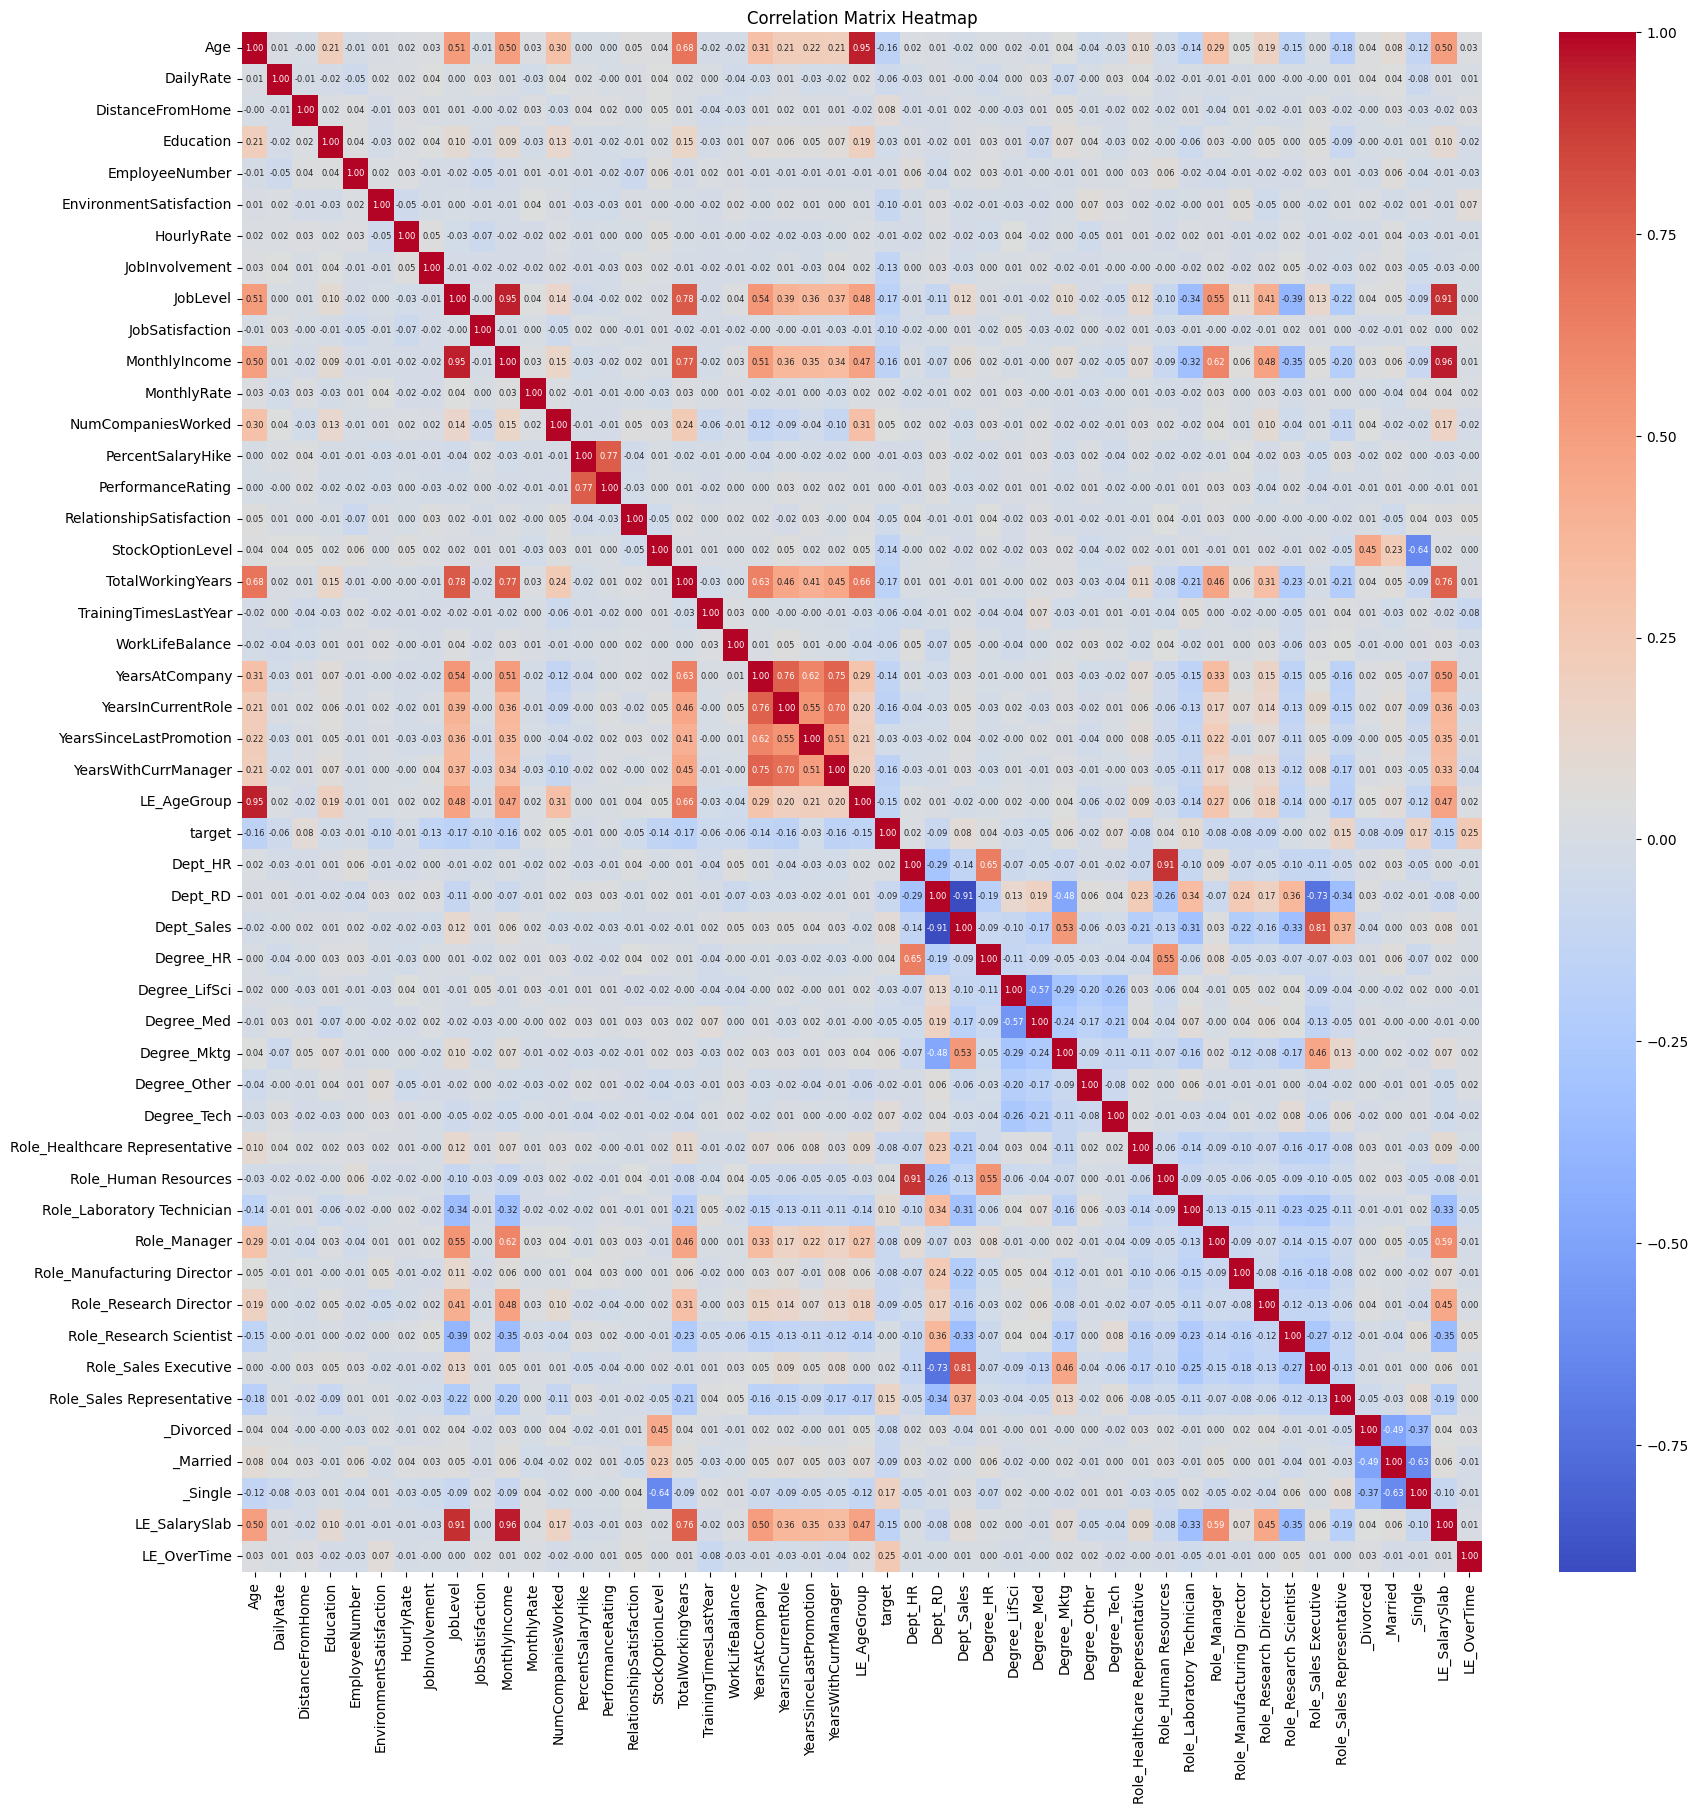

In [25]:
corr_mat = data[num_cols].corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

plt.title('Correlation Matrix Heatmap')
plt.show()

In [26]:
FeatureSelector.get_high_corr_vars(data)

Age - LE_AgeGroup: 0.95
JobLevel - MonthlyIncome: 0.95
JobLevel - LE_SalarySlab: 0.91
MonthlyIncome - LE_SalarySlab: 0.96
Dept_HR - Role_Human Resources: 0.91


In [27]:
feature_cols = [col for col in num_cols if col not in ['LE_AgeGroup', 'LE_SalarySlab', 'target']]
X = data[feature_cols]
y = data['target']

### Linear Regression

In [28]:
logreg_space = {
    'C': hp.loguniform('C', np.log(1e-4), np.log(1e4)),  # Log-uniform distribution for regularization strength
    'penalty': hp.choice('penalty', ['l1', 'l2', 'elasticnet', 'none']),  # Regularization type
    'solver': hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear', 'saga']),  # Optimization algorithm
    'max_iter': hp.quniform('max_iter', 100, 1000, 10),  # Integer number of iterations
    'class_weight': hp.choice('class_weight', [None, 'balanced', {'0': 1, '1': 5}]),  # Handling class imbalance
    'tol': hp.loguniform('tol', np.log(1e-6), np.log(1e-3))  # Tolerance for stopping criteria
}
model = LogisticRegression(random_state = 42)
lr, lr_results = Models.optimize_model(logreg_space, model, X, y, 500, -1)

100%|██████████| 500/500 [01:29<00:00,  5.57trial/s, best loss: -0.3153080999841797]


In [29]:
lr_results

,params,loss,status,accuracy,precision,recall,f1,f2,roc_auc,pr_auc
30,"{'C': [0.12154666002543416], 'class_weight': [...",-0.315308,ok,0.839189,0.500000,0.630616,0.556305,0.598157,0.828370,0.596655
11,"{'C': [0.5978313160182299], 'class_weight': [0...",-0.309720,ok,0.836486,0.493333,0.627810,0.549604,0.593145,0.831264,0.614867
24,"{'C': [1.9860113423340477], 'class_weight': [0...",-0.289723,ok,0.831081,0.480000,0.603591,0.533157,0.572808,0.823804,0.595442
20,"{'C': [1333.1369139347917], 'class_weight': [0...",-0.278058,ok,0.827027,0.470000,0.591613,0.519213,0.558659,0.817315,0.583677
16,"{'C': [0.0009766658672048254], 'class_weight':...",-0.275726,ok,0.825676,0.466667,0.590842,0.518707,0.558794,0.815898,0.565214
40,"{'C': [1.397077960643731], 'class_weight': [1]...",-0.265791,ok,0.822973,0.460000,0.577806,0.511313,0.548925,0.820323,0.569796
44,"{'C': [1830.3659690776026], 'class_weight': [0...",-0.196773,ok,0.797297,0.396667,0.496066,0.437357,0.469582,0.756293,0.403138
15,"{'C': [0.008699933211276947], 'class_weight': ...",-0.189447,ok,0.793243,0.386667,0.489949,0.426876,0.460540,0.747044,0.382992
22,"{'C': [3894.2490345685737], 'class_weight': [1...",-0.162036,ok,0.782432,0.360000,0.450101,0.398344,0.427325,0.725493,0.358838
10,"{'C': [0.18557646521768764], 'class_weight': [...",-0.152196,ok,0.777027,0.346667,0.439027,0.385786,0.415478,0.727610,0.336854


#### K-Nearest Neighbors Classification

In [30]:
knn_space = {
    'n_neighbors': hp.randint('n_neighbors', 50) + 1,  # Range: 1 to 50
    'weights': hp.choice('weights', ['uniform', 'distance']),
    'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
    'p': hp.choice('p', [1, 2]),
    'leaf_size': hp.randint('leaf_size', 40) + 10  # Range: 10 to 50
}
model = KNeighborsClassifier()
knn, knn_results = Models.optimize_model(knn_space, model, X, y, 100, -1)

100%|██████████| 100/100 [00:16<00:00,  5.98trial/s, best loss: -0.13786219710591865]


In [31]:
knn_results

,params,loss,status,accuracy,precision,recall,f1,f2,roc_auc,pr_auc
96,"{'algorithm': [2], 'leaf_size': [34], 'n_neigh...",-0.137862,ok,0.565541,0.214293,0.643334,0.320561,0.457608,0.606413,0.215395
72,"{'algorithm': [1], 'leaf_size': [31], 'n_neigh...",-0.135917,ok,0.564865,0.214214,0.634490,0.319184,0.453651,0.603269,0.220060
82,"{'algorithm': [0], 'leaf_size': [11], 'n_neigh...",-0.130679,ok,0.566892,0.210980,0.619390,0.314021,0.445170,0.609231,0.226881
50,"{'algorithm': [1], 'leaf_size': [11], 'n_neigh...",-0.127048,ok,0.560811,0.207148,0.613318,0.305748,0.433971,0.599861,0.210303
66,"{'algorithm': [1], 'leaf_size': [11], 'n_neigh...",-0.123778,ok,0.560135,0.205666,0.601839,0.305709,0.432888,0.578253,0.207565
...,...,...,...,...,...,...,...,...,...,...
15,"{'algorithm': [3], 'leaf_size': [9], 'n_neighb...",-0.000000,ok,0.745946,0.270000,0.353670,0.304179,0.331304,0.648000,0.278461
97,"{'algorithm': [2], 'leaf_size': [34], 'n_neigh...",-0.000000,ok,0.748649,0.276667,0.348311,0.307472,0.330454,0.662332,0.279799
98,"{'algorithm': [2], 'leaf_size': [34], 'n_neigh...",-0.000000,ok,0.665541,0.200778,0.359991,0.257260,0.310125,0.545011,0.186453
99,"{'algorithm': [2], 'leaf_size': [13], 'n_neigh...",-0.000000,ok,0.705405,0.223324,0.338278,0.266623,0.304418,0.612944,0.235161


#### RandomForest Classifier

In [32]:
rf_space = {
    'n_estimators': hp.randint('n_estimators', 2, 201),  # Number of trees in the forest
    'max_depth': hp.choice('max_depth', list(range(3, 51))),  # Max depth of the tree
    'min_samples_split': hp.randint('min_samples_split', 2, 500),  # Minimum number of samples to split
    'min_samples_leaf': hp.randint('min_samples_leaf', 2, 500),  # Minimum number of samples at a leaf node
    'max_features': hp.quniform('max_features', 0.01, 1, 0.01),  # Number of features to consider at each split
    'criterion': hp.choice('criterion', ['gini', 'entropy', 'log_loss']),
    'bootstrap': hp.choice('bootstrap', [True, False]),  # Whether to use bootstrap samples
}
model = RandomForestClassifier(random_state = 42)
rf, rf_results = Models.optimize_model(rf_space, model, X, y, 500, -1)

100%|██████████| 500/500 [12:52<00:00,  1.55s/trial, best loss: -0.2782767180718442]


In [33]:
with pd.option_context('display.max_columns', None, 'display.max_colwidth', None):
    display(rf_results)

,params,loss,status,accuracy,precision,recall,f1,f2,roc_auc,pr_auc
458,"{'bootstrap': [0], 'criterion': [1], 'max_depth': [20], 'max_features': [0.8], 'min_samples_leaf': [21], 'min_samples_split': [11], 'n_estimators': [186]}",-0.278277,ok,0.827027,0.470000,0.592078,0.521903,0.561037,0.789576,0.520173
489,"{'bootstrap': [0], 'criterion': [1], 'max_depth': [47], 'max_features': [0.64], 'min_samples_leaf': [21], 'min_samples_split': [11], 'n_estimators': [124]}",-0.273585,ok,0.824324,0.463333,0.590471,0.517586,0.558415,0.793591,0.510807
112,"{'bootstrap': [0], 'criterion': [1], 'max_depth': [12], 'max_features': [0.29], 'min_samples_leaf': [10], 'min_samples_split': [34], 'n_estimators': [189]}",-0.267944,ok,0.824324,0.463333,0.578297,0.512696,0.549513,0.779629,0.532151
78,"{'bootstrap': [0], 'criterion': [1], 'max_depth': [15], 'max_features': [0.64], 'min_samples_leaf': [24], 'min_samples_split': [40], 'n_estimators': [182]}",-0.265706,ok,0.822973,0.460000,0.577622,0.509619,0.547489,0.778874,0.500062
261,"{'bootstrap': [0], 'criterion': [1], 'max_depth': [10], 'max_features': [0.86], 'min_samples_leaf': [25], 'min_samples_split': [32], 'n_estimators': [31]}",-0.262239,ok,0.821622,0.456667,0.574246,0.506597,0.544394,0.780174,0.483798
...,...,...,...,...,...,...,...,...,...,...
464,"{'bootstrap': [0], 'criterion': [2], 'max_depth': [20], 'max_features': [0.88], 'min_samples_leaf': [242], 'min_samples_split': [452], 'n_estimators': [49]}",-0.000000,ok,0.754730,0.301349,0.398519,0.342844,0.374091,0.683171,0.328300
469,"{'bootstrap': [0], 'criterion': [1], 'max_depth': [35], 'max_features': [0.87], 'min_samples_leaf': [450], 'min_samples_split': [145], 'n_estimators': [183]}",-0.000000,ok,0.160811,0.160811,1.000000,0.276928,0.488821,0.500000,0.160811
38,"{'bootstrap': [0], 'criterion': [2], 'max_depth': [47], 'max_features': [1.0], 'min_samples_leaf': [463], 'min_samples_split': [492], 'n_estimators': [47]}",-0.000000,ok,0.160811,0.160811,1.000000,0.276617,0.487704,0.500000,0.160811
31,"{'bootstrap': [0], 'criterion': [2], 'max_depth': [32], 'max_features': [0.45], 'min_samples_leaf': [470], 'min_samples_split': [31], 'n_estimators': [127]}",-0.000000,ok,0.160811,0.160811,1.000000,0.275988,0.485314,0.500000,0.160811


#### LightGBM

In [34]:
lgbm_space = {
    'max_depth': hp.quniform("max_depth", 3, 10, 1),  #Max depth 10
    'gamma': hp.loguniform('gamma', np.log(1), np.log(100)),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.loguniform('min_child_weight',np.log(1), np.log(100)),
    'n_estimators': hp.quniform('n_estimators', 50, 250, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'random_state': 42,   
    'verbose': -1
}
model = lightgbm.LGBMClassifier()
lgbm, lgbm_results = Models.optimize_model(lgbm_space, model, X, y, 1000, -1)

100%|██████████| 1000/1000 [07:18<00:00,  2.28trial/s, best loss: -0.34949251379038604]


In [35]:
with pd.option_context('display.max_columns', None, 'display.max_colwidth', None):
    display(lgbm_results)

,params,loss,status,accuracy,precision,recall,f1,f2,roc_auc,pr_auc
648,"{'colsample_bytree': [0.5555444390974287], 'gamma': [62.75421968399085], 'learning_rate': [0.13611044389476398], 'max_depth': [9.0], 'min_child_weight': [17.09673302967595], 'n_estimators': [174.0], 'reg_alpha': [2.4466057541072126], 'reg_lambda': [3.306059607492113], 'subsample': [0.5795295900574703]}",-0.349493,ok,0.850000,0.526667,0.663593,0.587078,0.630654,0.821394,0.599721
528,"{'colsample_bytree': [0.7629069125450563], 'gamma': [1.7806263284379245], 'learning_rate': [0.11326477154538885], 'max_depth': [5.0], 'min_child_weight': [22.094416053448864], 'n_estimators': [147.0], 'reg_alpha': [3.080172061776305], 'reg_lambda': [3.169433021710737], 'subsample': [0.5653020089997668]}",-0.340676,ok,0.847297,0.520000,0.655147,0.579341,0.622407,0.820055,0.603409
723,"{'colsample_bytree': [0.5440956807773905], 'gamma': [51.9794217957561], 'learning_rate': [0.1906579097637437], 'max_depth': [6.0], 'min_child_weight': [22.712800640808073], 'n_estimators': [143.0], 'reg_alpha': [4.922002345096638], 'reg_lambda': [3.4049418145295673], 'subsample': [0.6715728648661092]}",-0.339528,ok,0.845946,0.516667,0.657151,0.574584,0.620068,0.828324,0.610469
272,"{'colsample_bytree': [0.5744206539900887], 'gamma': [1.3425565050459314], 'learning_rate': [0.08827911796671252], 'max_depth': [10.0], 'min_child_weight': [11.956717413901725], 'n_estimators': [199.0], 'reg_alpha': [4.7892045615445085], 'reg_lambda': [2.897081434356628], 'subsample': [0.701305840084676]}",-0.338060,ok,0.845946,0.516667,0.654309,0.576403,0.620415,0.821834,0.601232
355,"{'colsample_bytree': [0.6487717484792971], 'gamma': [1.0023730689939443], 'learning_rate': [0.09763922618372368], 'max_depth': [3.0], 'min_child_weight': [14.479912496653238], 'n_estimators': [154.0], 'reg_alpha': [4.624906834376274], 'reg_lambda': [1.9380452788264098], 'subsample': [0.6685265790802599]}",-0.331991,ok,0.844595,0.513333,0.646735,0.571957,0.614456,0.823702,0.596484
...,...,...,...,...,...,...,...,...,...,...
211,"{'colsample_bytree': [0.6533042537420457], 'gamma': [3.1781420754587555], 'learning_rate': [0.08849943103582049], 'max_depth': [4.0], 'min_child_weight': [85.54667002286796], 'n_estimators': [100.0], 'reg_alpha': [7.80880855525504], 'reg_lambda': [1.9990700486234871], 'subsample': [0.6067431955061124]}",-0.000000,ok,0.160811,0.160811,1.000000,0.275878,0.485056,0.500000,0.160811
216,"{'colsample_bytree': [0.7742710118674274], 'gamma': [1.5735477398902016], 'learning_rate': [0.06624520782953937], 'max_depth': [3.0], 'min_child_weight': [99.03900337355813], 'n_estimators': [171.0], 'reg_alpha': [5.205226394644784], 'reg_lambda': [2.891787102177613], 'subsample': [0.5336573053865069]}",-0.000000,ok,0.160811,0.160811,1.000000,0.276657,0.487912,0.500000,0.160811
83,"{'colsample_bytree': [0.7477133082828555], 'gamma': [4.007943779252637], 'learning_rate': [0.10405147951455568], 'max_depth': [9.0], 'min_child_weight': [96.18142763856096], 'n_estimators': [162.0], 'reg_alpha': [2.2123280447144937], 'reg_lambda': [0.2590737970291599], 'subsample': [0.6987887667401951]}",-0.000000,ok,0.160811,0.160811,1.000000,0.276037,0.485751,0.500000,0.160811
32,"{'colsample_bytree': [0.6715508822277989], 'gamma': [80.70863261101839], 'learning_rate': [0.035914476207915304], 'max_depth': [10.0], 'min_child_weight': [89.96885124261688], 'n_estimators': [208.0], 'reg_alpha': [5.465559285118759], 'reg_lambda': [4.442427161027867], 'subsample': [0.8055788799413608]}",-0.000000,ok,0.160811,0.160811,1.000000,0.276532,0.487382,0.500000,0.160811


#### XGBoost

In [36]:
xgb_space = {
    'max_depth': hp.quniform("max_depth", 3, 10, 1),  #Max depth 10
    'gamma': hp.loguniform('gamma', np.log(1), np.log(100)),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.loguniform('min_child_weight',np.log(1), np.log(100)),
    'n_estimators': hp.quniform('n_estimators', 50, 250, 1),
    #'booster': hp.choice('booster', ['gbtree', 'gblinear', 'dart']),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    #'scale_pos_weight': hp.quniform('scale_pos_weight', 1, 50, 5),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'random_state': 42,   
}

model = xgb.XGBClassifier()
xgb, xgb_results = Models.optimize_model(xgb_space, model, X, y, 500, -1)

100%|██████████| 500/500 [07:17<00:00,  1.14trial/s, best loss: -0.3325493815739884]


In [37]:
with pd.option_context('display.max_columns', None, 'display.max_colwidth', None):
    display(xgb_results)

,params,loss,status,accuracy,precision,recall,f1,f2,roc_auc,pr_auc
203,"{'colsample_bytree': [0.5312780904562849], 'gamma': [1.4088093014784722], 'learning_rate': [0.06912377996145089], 'max_depth': [7.0], 'min_child_weight': [2.061768566496442], 'n_estimators': [233.0], 'reg_alpha': [3.411224920178748], 'reg_lambda': [2.512369331558717], 'subsample': [0.7316760653988026]}",-0.332549,ok,0.844595,0.513333,0.647823,0.571919,0.614897,0.820618,0.598752
76,"{'colsample_bytree': [0.6736307344931076], 'gamma': [1.9118366423998847], 'learning_rate': [0.17732439162427832], 'max_depth': [7.0], 'min_child_weight': [2.974904822274176], 'n_estimators': [137.0], 'reg_alpha': [2.9068692600435204], 'reg_lambda': [0.9068218550171316], 'subsample': [0.6409646313985835]}",-0.330650,ok,0.843243,0.510000,0.648333,0.569510,0.613863,0.816012,0.584418
146,"{'colsample_bytree': [0.7041426587693239], 'gamma': [1.1093465090712162], 'learning_rate': [0.19238919629440643], 'max_depth': [10.0], 'min_child_weight': [2.6223640979177305], 'n_estimators': [235.0], 'reg_alpha': [1.1214166199763613], 'reg_lambda': [8.647400069215712], 'subsample': [0.5210019063725283]}",-0.329483,ok,0.843243,0.510000,0.646046,0.567421,0.611170,0.819715,0.597344
321,"{'colsample_bytree': [0.6730154537940479], 'gamma': [1.0372626049037024], 'learning_rate': [0.199385103858674], 'max_depth': [8.0], 'min_child_weight': [6.315317301249341], 'n_estimators': [220.0], 'reg_alpha': [3.641811815409419], 'reg_lambda': [9.9866897250392], 'subsample': [0.5027822490989521]}",-0.329432,ok,0.843243,0.510000,0.645946,0.568208,0.611864,0.822778,0.609257
390,"{'colsample_bytree': [0.5224824100736046], 'gamma': [1.2249363784772673], 'learning_rate': [0.10638536003493068], 'max_depth': [5.0], 'min_child_weight': [1.1747055331904603], 'n_estimators': [189.0], 'reg_alpha': [5.795555134373794], 'reg_lambda': [3.569319651975289], 'subsample': [0.7011826649049281]}",-0.329285,ok,0.841892,0.506667,0.649905,0.566605,0.612847,0.823350,0.606213
...,...,...,...,...,...,...,...,...,...,...
55,"{'colsample_bytree': [0.6719568499993368], 'gamma': [7.144141683788174], 'learning_rate': [0.07008845492953146], 'max_depth': [4.0], 'min_child_weight': [93.06153395679715], 'n_estimators': [97.0], 'reg_alpha': [9.411773712805719], 'reg_lambda': [5.626056665714718], 'subsample': [0.5270722251445498]}",-0.000000,ok,0.160811,0.160811,1.000000,0.276754,0.488212,0.500000,0.160811
46,"{'colsample_bytree': [0.75655684576076], 'gamma': [60.95291472399713], 'learning_rate': [0.02488837477511727], 'max_depth': [5.0], 'min_child_weight': [15.186102948318158], 'n_estimators': [145.0], 'reg_alpha': [7.164094097619518], 'reg_lambda': [0.1093853619683447], 'subsample': [0.7551923626467771]}",-0.000000,ok,0.160811,0.160811,1.000000,0.276900,0.488729,0.500000,0.160811
1,"{'colsample_bytree': [0.9416024863020325], 'gamma': [59.046532388397075], 'learning_rate': [0.030830141089188006], 'max_depth': [4.0], 'min_child_weight': [1.9574643369004028], 'n_estimators': [176.0], 'reg_alpha': [6.614499456116962], 'reg_lambda': [3.078543794718266], 'subsample': [0.5197402881308704]}",-0.000000,ok,0.160811,0.160811,1.000000,0.276917,0.488780,0.500000,0.160811
0,"{'colsample_bytree': [0.5521699615973427], 'gamma': [13.937638156087605], 'learning_rate': [0.05410632458923513], 'max_depth': [5.0], 'min_child_weight': [66.83413158234238], 'n_estimators': [135.0], 'reg_alpha': [8.8278058108884], 'reg_lambda': [7.9238935474121694], 'subsample': [0.5147760435835347]}",-0.000000,ok,0.160811,0.160811,1.000000,0.276439,0.487169,0.500000,0.160811
